# Install libraries

In [ ]:
!pip install transformers datasets seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 K

In [ ]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (12.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

# Import Libraries

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import numpy as np
from PIL import Image, ImageDraw
from transformers import LayoutLMv3ForTokenClassification
from transformers import AutoProcessor
import torch


# Read data

In [ ]:
image = Image.open("test.png")
image = image.convert("RGB")
image

In [ ]:
ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)

In [ ]:
# https://huggingface.co/datasets/nielsr/funsd-layoutlmv3/blob/main/funsd-layoutlmv3.py
def get_line_bbox( bboxs):
        x = [bboxs[i][j] for i in range(len(bboxs)) for j in range(0, len(bboxs[i]), 2)]
        y = [bboxs[i][j] for i in range(len(bboxs)) for j in range(1, len(bboxs[i]), 2)]

        x0, y0, x1, y1 = min(x), min(y), max(x), max(y)

        assert x1 >= x0 and y1 >= y0
        bbox = [x0, y0, x1, y1]
        return bbox

In [ ]:
texts_list = []
bboxs_list =[]

for i, j in ocr_df.groupby('block_num'):
  text = ' '.join(j['text'])
  if text != ' ' and text.strip()!='':
    texts_list.append(text)
    box = []
    for left, top, width, height in zip(j['left'].tolist(), j['top'].tolist(), j['width'].tolist(), j['height'].tolist()):
      box.append([left, top, left+width, top+height])
  
    bboxs_list.append(get_line_bbox(box))

In [ ]:
len(texts_list), len(bboxs_list)

(11, 11)

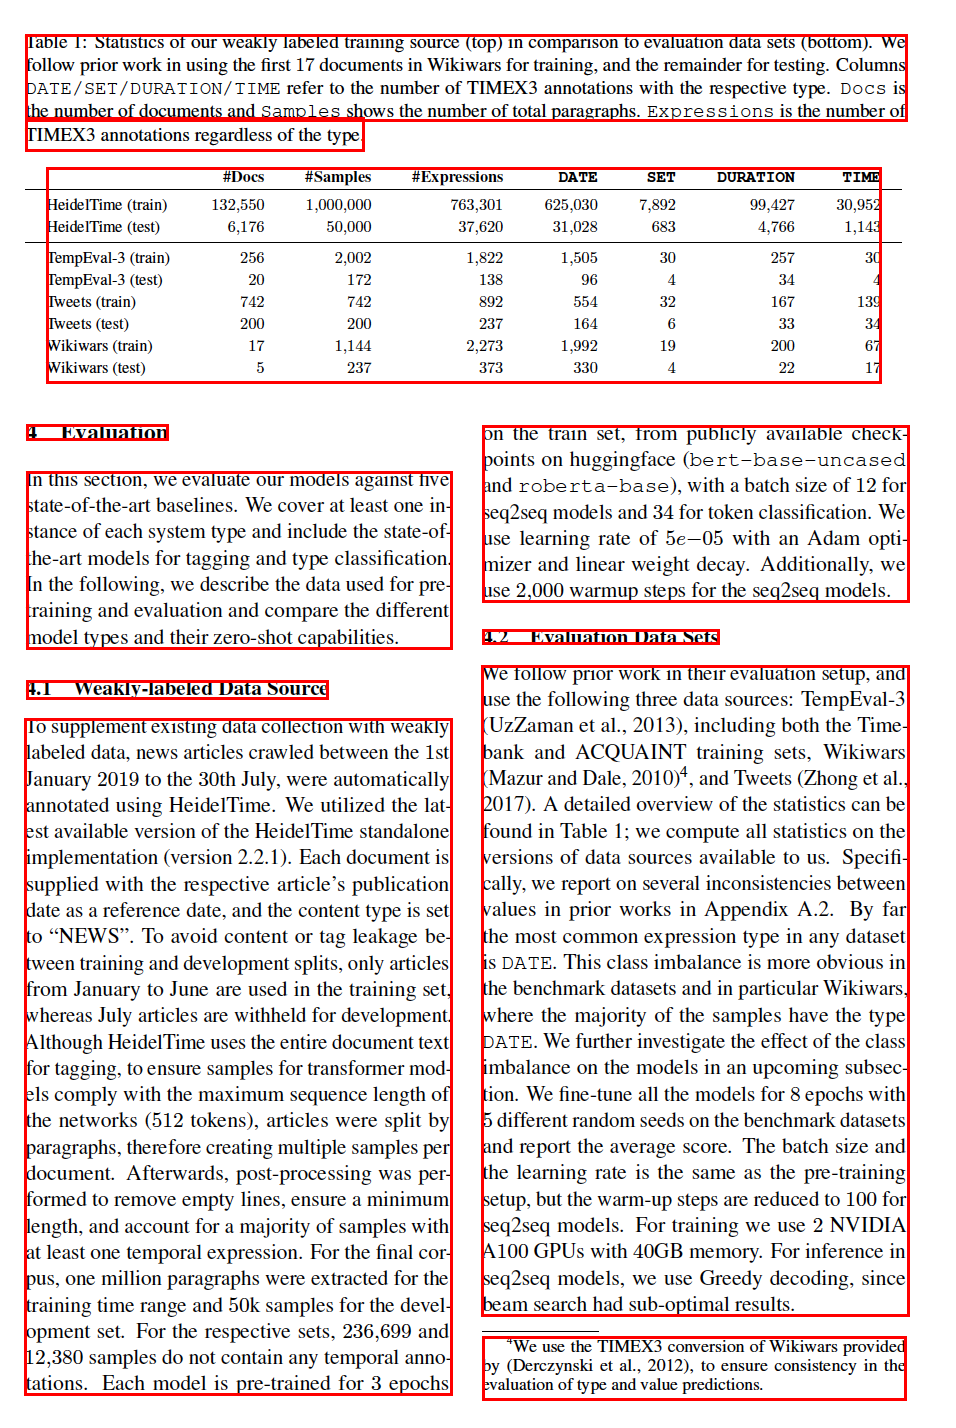

In [ ]:
# Load the image
# image screenshot https://www.researchgate.net/publication/354983472_BERT_got_a_Date_Introducing_Transformers_to_Temporal_Tagging
image_path = "test.png"
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
# Define the bounding box
for bounding_box in bboxs_list:
    draw.rectangle(bounding_box, outline="red", width=3)
image

In [ ]:
def normalized_box(box, image_width, image_height):
    return [
        int(1000 * (box[0] / image_width)),
        int(1000 * (box[1] / image_height)),
        int(1000 * (box[2] / image_width)),
        int(1000 * (box[3] / image_height)),
    ]

In [ ]:
img = Image.open(image_path).convert('RGB')
image_width, image_height = img.size
normalized_bboxes_list = [normalized_box(bboxs, image_width, image_height) for bboxs in bboxs_list]


In [ ]:
# Mit1208/layoutlmv3-finetuned-DocLayNet
model = LayoutLMv3ForTokenClassification.from_pretrained("Mit1208/layoutlmv3-finetuned-DocLayNet")     

In [ ]:
processor = AutoProcessor.from_pretrained("Mit1208/layoutlmv3-finetuned-DocLayNet", apply_ocr=False)

In [ ]:
encoding = processor(img, texts_list, boxes=normalized_bboxes_list, truncation=True, stride =128, 
         padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)

offset_mapping = encoding.pop('offset_mapping')

overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

In [ ]:
# change the shape of input_ids

x = []
for i in range(0, len(encoding['input_ids'])):
     x.append(torch.tensor(encoding['input_ids'][i]))
x = torch.stack(x)
encoding['input_ids'] = x

In [ ]:
# change the shape of pixel values

x = []
for i in range(0, len(encoding['pixel_values'])):
     x.append(torch.from_numpy(encoding['pixel_values'][i]))
x = torch.stack(x)
encoding['pixel_values'] = x

In [ ]:
# change the shape of attention_mask

x = []
for i in range(0, len(encoding['attention_mask'])):
     x.append(torch.tensor(encoding['attention_mask'][i]))
x = torch.stack(x)
encoding['attention_mask'] = x

In [ ]:
# change the shape of bbox
x = []
for i in range(0, len(encoding['bbox'])):
     x.append(torch.tensor(encoding['bbox'][i]))
x = torch.stack(x)
encoding['bbox'] = x

In [ ]:
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([3, 512])
attention_mask torch.Size([3, 512])
bbox torch.Size([3, 512, 4])
pixel_values torch.Size([3, 3, 224, 224])


In [ ]:
outputs = model(**encoding)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
logits = outputs.logits

predictions = logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

if (len(token_boxes) == 512):
  predictions = [predictions]
  token_boxes = [token_boxes]

In [ ]:
import itertools

predictions = list(itertools.chain(*predictions))
token_boxes = list(itertools.chain(*token_boxes))

In [ ]:
len(token_boxes)

1536

In [ ]:
def unnormalize_box(bbox, width, height):
    # print(bbox)
    return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


width, height = img.size
print(width, height)
true_predictions = [model.config.id2label[pred] for pred in predictions ]
true_boxes = [unnormalize_box(box, width, height) for box in token_boxes]

956 1428


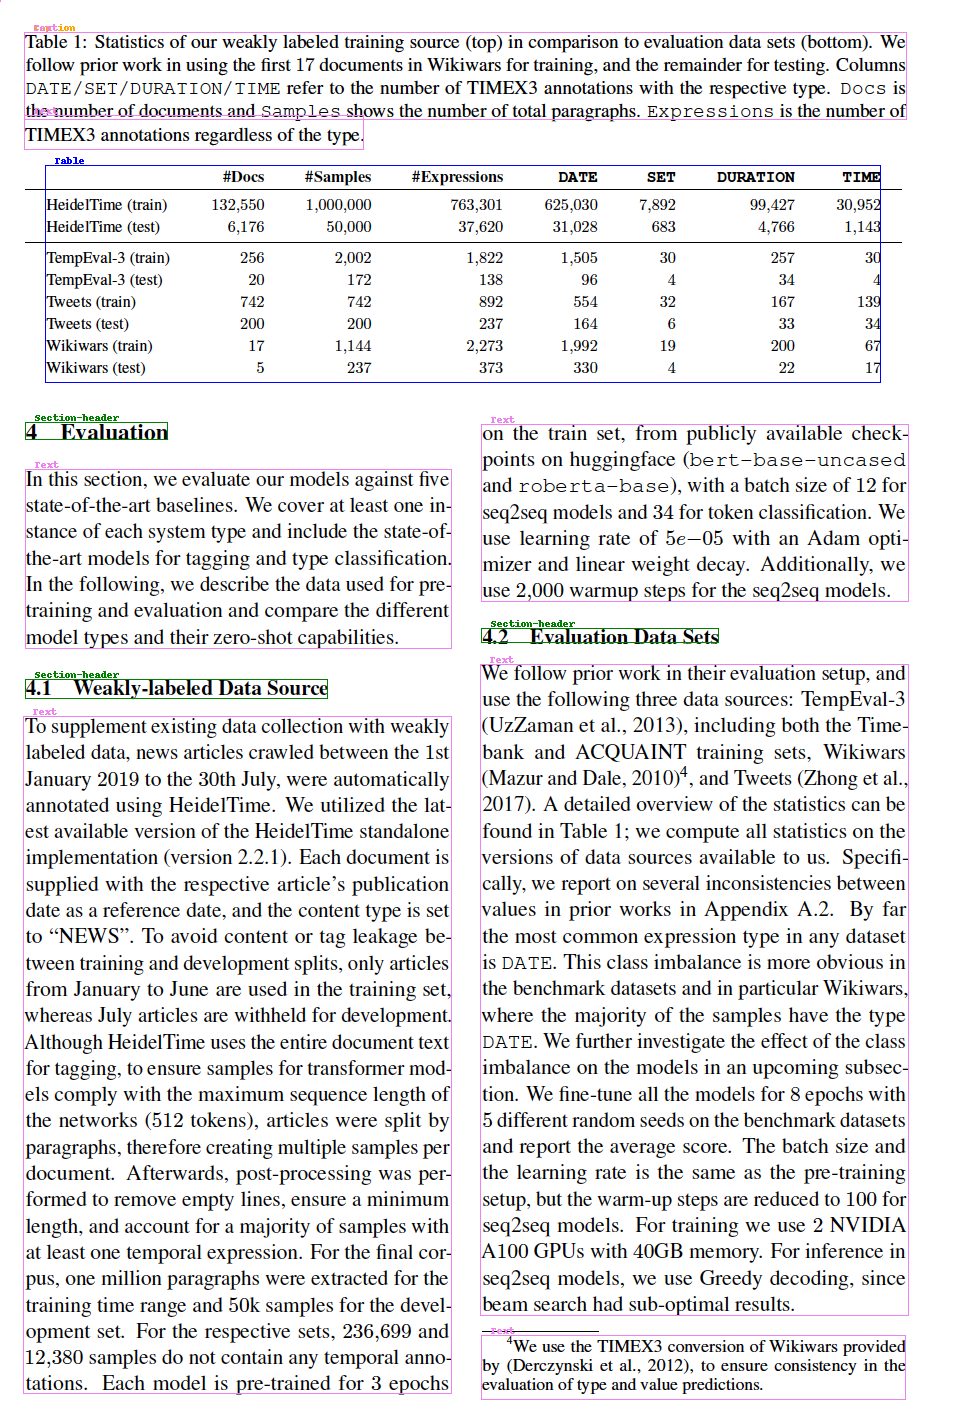

In [ ]:

from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(img)

font = ImageFont.load_default()


label2color = {'Table':'blue', 'Section-header':'green', 'Caption':'orange', 'Text':'violet'}

for predicted_label, box in zip(true_predictions, true_boxes):
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

img